# 02-02 : Time Series

Experiment with the data as a time series.

In [1]:
import sys
import gc
import logging

from typing import Iterable
from typing import Tuple, List

from itertools import islice

import pandas as pd
import numpy as np

import tensorflow as tf

import keras
from keras import optimizers
from keras.models import Sequential, Model

from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import LeakyReLU, LSTM, MaxPooling2D, concatenate, Reshape
from keras.layers import Concatenate

from keras.layers import Input
from keras import callbacks
from keras import regularizers

from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

2023-03-16 11:45:08.897102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 11:45:09.343353: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 11:45:09.515151: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/current/lib/native:/opt/hadoop/current/lib/native
2023-03-16 11:45:09.5

In [2]:
# Set the GPU memory from growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


2023-03-16 11:45:16.705057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/current/lib/native:/opt/hadoop/current/lib/native
2023-03-16 11:45:16.753243: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-16 11:45:16.753335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lena): /proc/driver/nvidia/version does not exist


## Configure Logging

In [3]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [4]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.FileHandler("ex05_06.log"),
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-16 11:45:17 INFO     Started


## Load Source Data

In [5]:
dtypes = {
    "session_id": "category",
    "elapsed_time": np.int32,
    "event_name": "category",
    "name": "category",
    "level": np.uint8,
    "page": "category",
    "room_coor_x": np.float32,
    "room_coor_y": np.float32,
    "screen_coor_x": np.float32,
    "screen_coor_y": np.float32,
    "hover_duration": np.float32,
    "text": "category",
    "fqid": "category",
    "room_fqid": "category",
    "text_fqid": "category",
    "fullscreen": "category",
    "hq": "category",
    "music": "category",
    "level_group": "category",
}

In [6]:
# load the source training set
df_source = pd.read_csv('../data/train.csv.gz', compression='gzip', dtype=dtypes)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [7]:
# load the source training labels
df_source_labels = pd.read_csv('../data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

In [8]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

In [9]:
def find_problem_sessions(data : pd.DataFrame) -> List[str]:
    """
    Finds the sessions that are duplicated on session_id and index. And
    Find sessions with reversed indexes.

    This idea is taken from the following Kaggle notebook:
    https://www.kaggle.com/code/abaojiang/eda-on-game-progress/notebook?scriptVersionId=120133716
    
    Parameters
    ----------
    data : pd.DataFrame
        The data to search.

    Returns
    -------
    List[str]
        The list of session ids that have a problem.
    """

    # find sessions duplicated on session_id and index
    sessions_with_duplicates = df_source.loc[
        data.duplicated(subset=["session_id", "index"], keep=False)] \
        ["session_id"].unique().tolist()


    # find sessions with reversed indexes
    sessions_with_reversed_index = []
    for sess_id, gp in df_source.groupby("session_id", observed=True):
        if not gp["index"].is_monotonic_increasing:
            sessions_with_reversed_index.append(sess_id)

    # via experimentation these sessions have been found to have time 
    # differences < -2000
    negative_time_diff_sessions = [
        '21030417085341900', '21070111080982292', 
        '21090108302064196', '21090409222921812']

    # combine the two lists into a single set
    return set(sessions_with_duplicates + sessions_with_reversed_index + negative_time_diff_sessions)


In [10]:
def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [11]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)
    
    return df_main

## Data Preprocessing

In [12]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

# remove sessions with problems
problem_sessions = find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13013176, 14)


,session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,-413.991394,-159.314682,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,-413.991394,-159.314682,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,-413.991394,-159.314682,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [13]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


## Functions to Create Features

### Create Initial Features

In [14]:
def create_initial_features(X:pd.DataFrame,
                            y:pd.DataFrame) -> pd.DataFrame:
    """
    Creates the initial dataset to which features will be added.
    """
    df_features =  df_source_labels \
        .groupby(['session_id', 'level_group']) \
        .agg({'correct': ['count']}) \
        .reset_index() \
        .droplevel(1, axis=1) \
        .drop(columns=['correct']) \
        .sort_values(['session_id', 'level_group']) \
        
    # set the session_id to be an integer
    df_features['session_id'] = df_features['session_id'].astype(int)
        
    return df_features        

# test the function
df_features = create_initial_features(df_source, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group
0,20090312431273200,0-4
1,20090312431273200,13-22
2,20090312431273200,5-12
3,20090312433251036,0-4
4,20090312433251036,13-22
5,20090312433251036,5-12


### Time Series

In [15]:
# the limit of the maximum amount of one-hot columns to create for a single column
MAX_DUMMIES = 25

# the maximum number of events to include in a single time series
MAX_EVENTS = 500

In [16]:
LEVEL_COLUMNS = [
    'level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5', 
    'level_6', 'level_7', 'level_8', 'level_9', 'level_10', 'level_11', 
    'level_12', 'level_13', 'level_14', 'level_15', 'level_16', 'level_17', 
    'level_18', 'level_19', 'level_20', 'level_21', 'level_22']

EVENT_NAME_COLUMNS = [
    'event_name_checkpoint', 'event_name_cutscene_click', 'event_name_map_click', 
    'event_name_map_hover', 'event_name_navigate_click', 'event_name_notebook_click', 
    'event_name_notification_click', 'event_name_object_click', 'event_name_object_hover', 
    'event_name_observation_click', 'event_name_person_click']

ROOM_FQID_COLUMNS = [
    'room_fqid_tunic.capitol_0.hall', 'room_fqid_tunic.capitol_1.hall', 
    'room_fqid_tunic.capitol_2.hall', 'room_fqid_tunic.drycleaner.frontdesk', 
    'room_fqid_tunic.flaghouse.entry', 'room_fqid_tunic.historicalsociety.basement', 
    'room_fqid_tunic.historicalsociety.cage', 'room_fqid_tunic.historicalsociety.closet', 
    'room_fqid_tunic.historicalsociety.closet_dirty', 'room_fqid_tunic.historicalsociety.collection', 
    'room_fqid_tunic.historicalsociety.collection_flag', 'room_fqid_tunic.historicalsociety.entry', 
    'room_fqid_tunic.historicalsociety.frontdesk', 'room_fqid_tunic.historicalsociety.stacks', 
    'room_fqid_tunic.humanecology.frontdesk', 'room_fqid_tunic.kohlcenter.halloffame', 
    'room_fqid_tunic.library.frontdesk', 'room_fqid_tunic.library.microfiche', 
    'room_fqid_tunic.wildlife.center']

NAME_COLUMNS = [
    'name_basic', 'name_close', 'name_next', 'name_open', 'name_prev', 'name_undefined']

FQID_COLUMNS = [
    'fqid_worker', 'fqid_archivist', 'fqid_gramps', 'fqid_wells', 'fqid_toentry', 
    'fqid_confrontation', 'fqid_crane_ranger', 'fqid_groupconvo', 'fqid_flag_girl', 
    'fqid_tomap', 'fqid_tostacks', 'fqid_tobasement', 'fqid_archivist_glasses', 
    'fqid_boss', 'fqid_journals', 'fqid_seescratches', 'fqid_groupconvo_flag', 
    'fqid_cs', 'fqid_teddy', 'fqid_expert', 'fqid_businesscards', 'fqid_ch3start', 
    'fqid_tunic.historicalsociety', 'fqid_tofrontdesk', 'fqid_savedteddy']

TEXT_FQID_COLUMNS = [
    'text_fqid_tunic.historicalsociety.cage.confrontation', 
    'text_fqid_tunic.wildlife.center.crane_ranger.crane', 
    'text_fqid_tunic.historicalsociety.frontdesk.archivist.newspaper', 
    'text_fqid_tunic.historicalsociety.entry.groupconvo', 
    'text_fqid_tunic.wildlife.center.wells.nodeer', 
    'text_fqid_tunic.historicalsociety.frontdesk.archivist.have_glass', 
    'text_fqid_tunic.drycleaner.frontdesk.worker.hub', 
    'text_fqid_tunic.historicalsociety.closet_dirty.gramps.news', 
    'text_fqid_tunic.humanecology.frontdesk.worker.intro', 
    'text_fqid_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 
    'text_fqid_tunic.historicalsociety.basement.seescratches', 
    'text_fqid_tunic.historicalsociety.collection.cs', 
    'text_fqid_tunic.flaghouse.entry.flag_girl.hello', 
    'text_fqid_tunic.historicalsociety.collection.gramps.found', 
    'text_fqid_tunic.historicalsociety.basement.ch3start', 
    'text_fqid_tunic.historicalsociety.entry.groupconvo_flag', 
    'text_fqid_tunic.library.frontdesk.worker.hello', 
    'text_fqid_tunic.library.frontdesk.worker.wells', 
    'text_fqid_tunic.historicalsociety.collection_flag.gramps.flag', 
    'text_fqid_tunic.historicalsociety.basement.savedteddy', 
    'text_fqid_tunic.library.frontdesk.worker.nelson', 
    'text_fqid_tunic.wildlife.center.expert.removed_cup', 
    'text_fqid_tunic.library.frontdesk.worker.flag', 
    'text_fqid_tunic.historicalsociety.frontdesk.archivist.hello', 
    'text_fqid_tunic.historicalsociety.closet.gramps.intro_0_cs_0']

In [17]:
# the categorical columns to use, and the order they are when limiting 
# the number to include.
CATEGORICAL_COLUMNS = {
    'level': LEVEL_COLUMNS,
    'event_name': EVENT_NAME_COLUMNS,
    'room_fqid': ROOM_FQID_COLUMNS,
    'name': NAME_COLUMNS,
    'fqid': FQID_COLUMNS,
    'text_fqid': TEXT_FQID_COLUMNS
}

# the base columns to include in the time series
STANDARD_COLUMNS = [
    'session_id',
    'index',
    'elapsed_time',
    'level_group'
]

In [18]:
print('UNIQUE COUNT')
for column in CATEGORICAL_COLUMNS:
    print(f'\t{column.ljust(11)}:', df_source[column].nunique())


UNIQUE COUNT
	level      : 23
	event_name : 11
	room_fqid  : 19
	name       : 6
	fqid       : 127
	text_fqid  : 126


In [19]:
def create_time_series_features(data:pd.DataFrame,
                                standard_columns:List[str]=STANDARD_COLUMNS,
                                categorical_columns:dict=CATEGORICAL_COLUMNS,
                                time_diff_min:int = 0,
                                time_dif_max:int = 3448) -> pd.DataFrame:
    """
    Creates the time series features for the entire dataset.
    The data are grouped by session_id and level_group, for example,
    when calculating the time difference between events.
    """
    # select the columns to use in the time series
    df_selected = data[
        standard_columns + 
        list(categorical_columns.keys())] \
        .sort_values('index') \

    # add the time difference between events
    df_selected['time_diff'] = df_selected \
        .groupby(['session_id', 'level_group'])['elapsed_time'] \
        .diff() \
        .fillna(0)

    # there can be negative time differences, so we need to remove them,
    # but within limits
    assert df_selected['time_diff'].min() > -2000

    df_selected['time_diff'] = df_selected['time_diff'] \
        .apply(lambda x: 0 if x < 0 else x)
    
    # clip the time difference to the min and max values
    if (time_diff_min is not None) and (time_dif_max is not None):
        df_selected['time_diff'] = df_selected['time_diff'] \
            .clip(time_diff_min, time_dif_max)
    
    df_selected = df_selected.sort_values(['session_id', 'level_group', 'index'])

    # convert the session_id to an integer
    df_selected['session_id'] = df_selected['session_id'].astype(int)

    return df_selected

# test the function
df_time_series_features = create_time_series_features(df_source)
with pd.option_context('display.max_columns', None):
    display(df_time_series_features.head(6))

,session_id,index,elapsed_time,level_group,level,event_name,room_fqid,name,fqid,text_fqid,time_diff
0,20090312431273200,0,0,0-4,0,cutscene_click,tunic.historicalsociety.closet,basic,intro,tunic.historicalsociety.closet.intro,0.0
1,20090312431273200,1,1323,0-4,0,person_click,tunic.historicalsociety.closet,basic,gramps,tunic.historicalsociety.closet.gramps.intro_0_...,1323.0
2,20090312431273200,2,831,0-4,0,person_click,tunic.historicalsociety.closet,basic,gramps,tunic.historicalsociety.closet.gramps.intro_0_...,0.0
3,20090312431273200,3,1147,0-4,0,person_click,tunic.historicalsociety.closet,basic,gramps,tunic.historicalsociety.closet.gramps.intro_0_...,316.0
4,20090312431273200,4,1863,0-4,0,person_click,tunic.historicalsociety.closet,basic,gramps,tunic.historicalsociety.closet.gramps.intro_0_...,716.0
5,20090312431273200,5,3423,0-4,0,person_click,tunic.historicalsociety.closet,basic,gramps,tunic.historicalsociety.closet.gramps.intro_0_...,1560.0


#### Determine the clipping values to remove outliers

count    1.301318e+07
mean     6.626066e+03
std      1.229935e+06
min      0.000000e+00
25%      4.530000e+02
50%      9.440000e+02
75%      1.651000e+03
max      1.746273e+09
Name: time_diff, dtype: float64



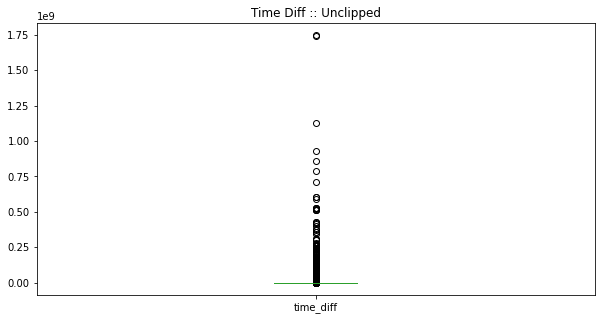

25% Quartile Time Difference: 453.0
75% Quartile Time Difference: 1651.0
IQR Time Difference: 1198.0
1.5 IQR Time Difference: 1797.0
Clip Min Time Difference: -1344.0
Clip Max Time Difference: 3448.0


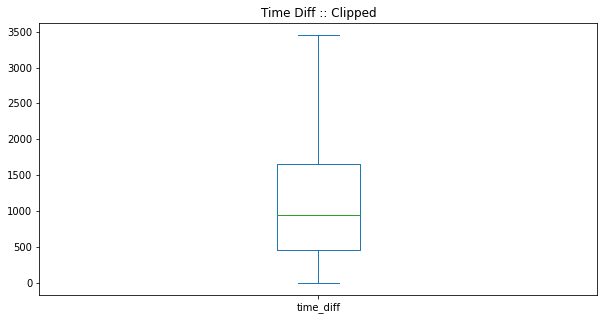

In [20]:
df_get_min_max = create_time_series_features(df_source, time_diff_min=None, time_dif_max=None)

# get the maximum and minimum time differences in the dataset
print(df_get_min_max['time_diff'].describe())
print()

# plot the time differences
df_get_min_max['time_diff'].plot(kind='box', title='Time Diff :: Unclipped', figsize=(10, 5))
plt.show()

q1 = df_get_min_max['time_diff'].quantile(0.25)
q3 = df_get_min_max['time_diff'].quantile(0.75)

print('25% Quartile Time Difference:', q1)
print('75% Quartile Time Difference:', q3)
print('IQR Time Difference:', q3 - q1)
print('1.5 IQR Time Difference:', 1.5 * (q3 - q1))
print('Clip Min Time Difference:', q1 - 1.5 * (q3 - q1))
print('Clip Max Time Difference:', q3 + 1.5 * (q3 - q1))

df_time_series_features['time_diff'].plot(kind='box', title='Time Diff :: Clipped', figsize=(10, 5))
plt.show()

#### Select One-Hot Columns to Use

These are added back to the CATEGORICAL_COLUMNS list.

In [21]:
def get_onehot_names(data:pd.DataFrame,
                     column:str)-> List[str]:
    """
    Returns the names of the one-hot columns for a given column.
    """
    # plot the number of unique values in the column
    data[column].value_counts().plot(kind='barh', title=column, figsize=(10, 5))

    columns = list(pd.get_dummies(df_time_series_features, columns=[column]).columns)
    print(columns[10:])

    return columns

['level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7', 'level_8', 'level_9', 'level_10', 'level_11', 'level_12', 'level_13', 'level_14', 'level_15', 'level_16', 'level_17', 'level_18', 'level_19', 'level_20', 'level_21', 'level_22']


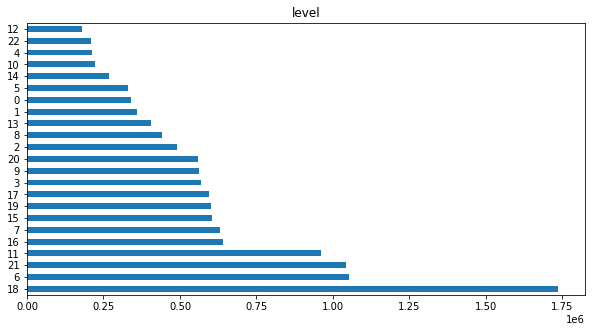

In [22]:
# level
_ = get_onehot_names(df_time_series_features, 'level')

['event_name_checkpoint', 'event_name_cutscene_click', 'event_name_map_click', 'event_name_map_hover', 'event_name_navigate_click', 'event_name_notebook_click', 'event_name_notification_click', 'event_name_object_click', 'event_name_object_hover', 'event_name_observation_click', 'event_name_person_click']


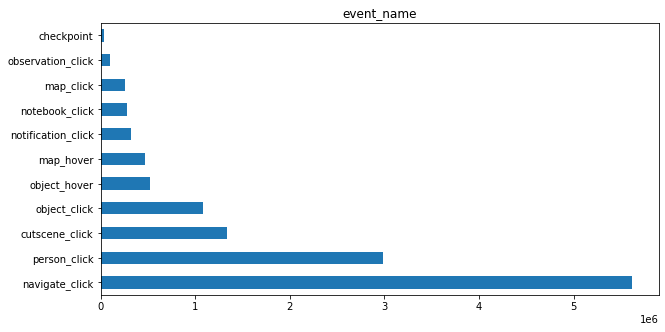

In [23]:
# event_name
_ = get_onehot_names(df_time_series_features, 'event_name')

['room_fqid_tunic.capitol_0.hall', 'room_fqid_tunic.capitol_1.hall', 'room_fqid_tunic.capitol_2.hall', 'room_fqid_tunic.drycleaner.frontdesk', 'room_fqid_tunic.flaghouse.entry', 'room_fqid_tunic.historicalsociety.basement', 'room_fqid_tunic.historicalsociety.cage', 'room_fqid_tunic.historicalsociety.closet', 'room_fqid_tunic.historicalsociety.closet_dirty', 'room_fqid_tunic.historicalsociety.collection', 'room_fqid_tunic.historicalsociety.collection_flag', 'room_fqid_tunic.historicalsociety.entry', 'room_fqid_tunic.historicalsociety.frontdesk', 'room_fqid_tunic.historicalsociety.stacks', 'room_fqid_tunic.humanecology.frontdesk', 'room_fqid_tunic.kohlcenter.halloffame', 'room_fqid_tunic.library.frontdesk', 'room_fqid_tunic.library.microfiche', 'room_fqid_tunic.wildlife.center']


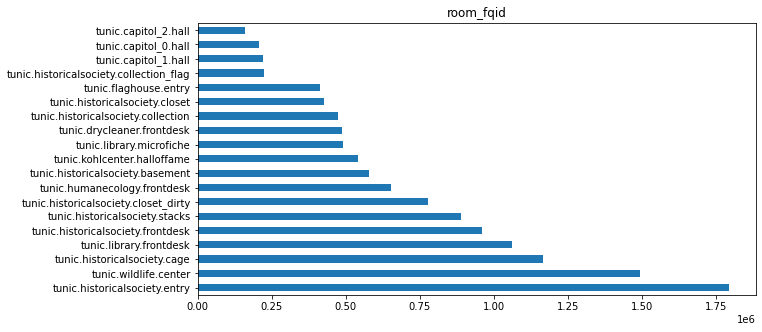

In [24]:
# room_fqid
_ = get_onehot_names(df_time_series_features, 'room_fqid')

['name_basic', 'name_close', 'name_next', 'name_open', 'name_prev', 'name_undefined']


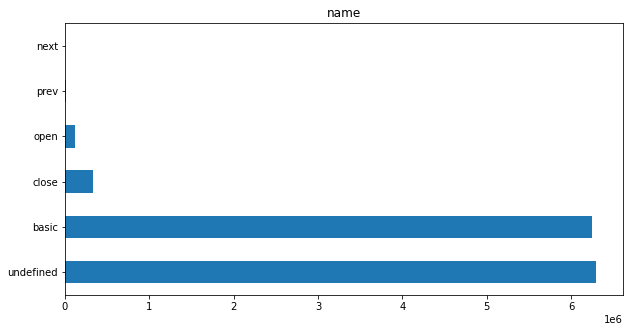

In [25]:
# name
_ = get_onehot_names(df_time_series_features, 'name')

['fqid_archivist', 'fqid_archivist_glasses', 'fqid_block', 'fqid_block_0', 'fqid_block_badge', 'fqid_block_magnify', 'fqid_block_nelson', 'fqid_block_tocollection', 'fqid_block_tomap1', 'fqid_block_tomap2', 'fqid_boss', 'fqid_businesscards', 'fqid_businesscards.card_0.next', 'fqid_businesscards.card_1.next', 'fqid_businesscards.card_bingo.bingo', 'fqid_businesscards.card_bingo.next', 'fqid_ch3start', 'fqid_chap1_finale', 'fqid_chap1_finale_c', 'fqid_chap2_finale_c', 'fqid_chap4_finale_c', 'fqid_coffee', 'fqid_colorbook', 'fqid_confrontation', 'fqid_crane_ranger', 'fqid_cs', 'fqid_directory', 'fqid_directory.closeup.archivist', 'fqid_door_block_clean', 'fqid_door_block_talk', 'fqid_doorblock', 'fqid_expert', 'fqid_flag_girl', 'fqid_glasses', 'fqid_gramps', 'fqid_groupconvo', 'fqid_groupconvo_flag', 'fqid_intro', 'fqid_janitor', 'fqid_journals', 'fqid_journals.hub.topics', 'fqid_journals.pic_0.next', 'fqid_journals.pic_1.next', 'fqid_journals.pic_2.bingo', 'fqid_journals.pic_2.next', 'fq

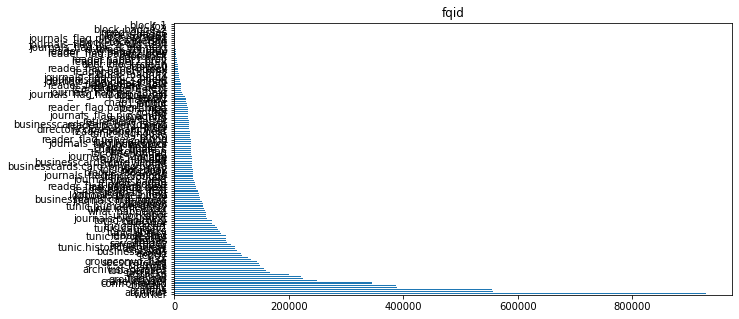

In [26]:
# get all fqid
fqid_columns = get_onehot_names(df_time_series_features, 'fqid')

# get the value for tje fqid column
fqid_value_counts = df_time_series_features['fqid'].value_counts()

# limit the columns to the MAX_DUMMIES count by selecting only the top categories
fqid_columns = fqid_value_counts[:MAX_DUMMIES].index.tolist()

# add the fqid_ prefix
fqid_columns = ['fqid_' + fqid for fqid in fqid_columns]

print()
print('limted fqid columns to', MAX_DUMMIES)
print(fqid_columns)

['text_fqid_tunic.capitol_0.hall.boss.talktogramps', 'text_fqid_tunic.capitol_0.hall.chap1_finale_c', 'text_fqid_tunic.capitol_1.hall.boss.haveyougotit', 'text_fqid_tunic.capitol_1.hall.boss.writeitup', 'text_fqid_tunic.capitol_2.hall.boss.haveyougotit', 'text_fqid_tunic.drycleaner.frontdesk.logbook.page.bingo', 'text_fqid_tunic.drycleaner.frontdesk.worker.done', 'text_fqid_tunic.drycleaner.frontdesk.worker.done2', 'text_fqid_tunic.drycleaner.frontdesk.worker.hub', 'text_fqid_tunic.drycleaner.frontdesk.worker.takealook', 'text_fqid_tunic.flaghouse.entry.colorbook', 'text_fqid_tunic.flaghouse.entry.flag_girl.hello', 'text_fqid_tunic.flaghouse.entry.flag_girl.hello_recap', 'text_fqid_tunic.flaghouse.entry.flag_girl.symbol', 'text_fqid_tunic.flaghouse.entry.flag_girl.symbol_recap', 'text_fqid_tunic.historicalsociety.basement.ch3start', 'text_fqid_tunic.historicalsociety.basement.gramps.seeyalater', 'text_fqid_tunic.historicalsociety.basement.gramps.whatdo', 'text_fqid_tunic.historicalsoci

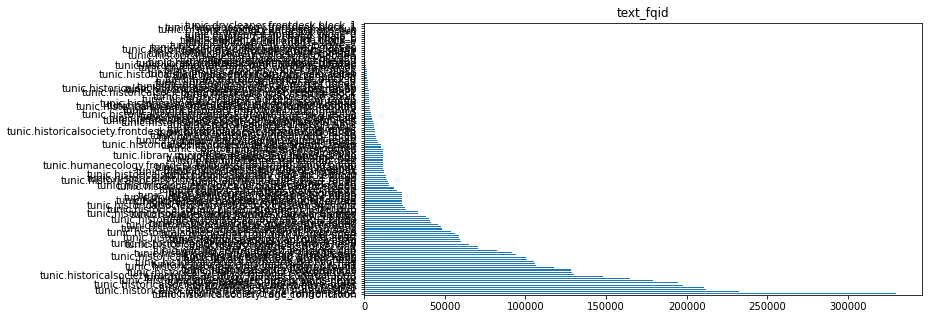

In [27]:
# get all text_fqid
text_fqid_columns = get_onehot_names(df_time_series_features, 'text_fqid')

# get the value for tje text_fqid column
text_fqid_value_counts = df_time_series_features['text_fqid'].value_counts()

# limit the columns to the MAX_DUMMIES count by selecting only the top categories
text_fqid_columns = text_fqid_value_counts[:MAX_DUMMIES].index.tolist()

# add the text_fqid_ prefix
text_fqid_columns = ['text_fqid_' + text_fqid for text_fqid in text_fqid_columns]

print()
print('limted text_fqid columns to', MAX_DUMMIES)
print(text_fqid_columns)

### Add Time Series Feature

In [28]:
def vectorize_column(data:pd.DataFrame,
                    column_name:str,
                    vector_columns:List[str])-> None:
    """
    Creates the one-hot columns for a given column.
    """
    # create the one-hot columns
    df_one_hot = pd.get_dummies(data, columns=[column_name])

    # add missing columns
    missing_columns = [column for column in vector_columns if column not in df_one_hot.columns]
    df_one_hot = pd.concat([
        df_one_hot, 
        pd.DataFrame(columns=missing_columns)], axis=1)
    
    # select the one-hot columns
    df_one_hot = df_one_hot[vector_columns].fillna(0)

    return df_one_hot

# test the function
session_id = 20090312431273200
level_group = '0-4'

column_name = 'fqid'
column_columns = CATEGORICAL_COLUMNS[column_name]

# select the data for the session_id and level_group
df_level_group = df_time_series_features[
    (df_time_series_features['session_id'] == session_id) & \
    (df_time_series_features['level_group'] == level_group)]

vectorize_column(df_level_group, column_name, column_columns)

,fqid_worker,fqid_archivist,fqid_gramps,fqid_wells,fqid_toentry,fqid_confrontation,fqid_crane_ranger,fqid_groupconvo,fqid_flag_girl,fqid_tomap,...,fqid_seescratches,fqid_groupconvo_flag,fqid_cs,fqid_teddy,fqid_expert,fqid_businesscards,fqid_ch3start,fqid_tunic.historicalsociety,fqid_tofrontdesk,fqid_savedteddy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# this is just used to test the function below
test_categorical_columns = dict(islice(CATEGORICAL_COLUMNS.items(), 1))
df_test_time_series = create_time_series_features(
    data=df_source,
    standard_columns=STANDARD_COLUMNS,
    categorical_columns=test_categorical_columns,
    time_diff_min=0,
    time_dif_max=3448)

with pd.option_context('display.max_columns', None):
    display(df_test_time_series.head(6))

,session_id,index,elapsed_time,level_group,level,time_diff
0,20090312431273200,0,0,0-4,0,0.0
1,20090312431273200,1,1323,0-4,0,1323.0
2,20090312431273200,2,831,0-4,0,0.0
3,20090312431273200,3,1147,0-4,0,316.0
4,20090312431273200,4,1863,0-4,0,716.0
5,20090312431273200,5,3423,0-4,0,1560.0


In [30]:
def vectorize_time_series(data:pd.DataFrame,
                          standard_columns:List[str]=STANDARD_COLUMNS,
                          categorical_columns:dict=CATEGORICAL_COLUMNS,
                          event_count:int=MAX_EVENTS) -> np.array:
    """
    Vectorize the time series data in a format suitable for TensorFlow training.
    """
    
    df_vectorized = data \
        .drop(columns=['session_id', 'elapsed_time', 'level_group']) \
        .drop(columns=categorical_columns.keys()) \
        .sort_values(by='index') \
        .drop(columns=['index'])

    # one-hot encode the categorical columns
    for column_name, vector_columns in categorical_columns.items():
        df_one_hot = vectorize_column(data, column_name, vector_columns)
        df_vectorized = pd.concat([df_vectorized, df_one_hot], axis=1)

    # limit the number of events
    df_vectorized = df_vectorized.head(event_count)
    #display(df_vectorized)

    # convert the data to a numpy array
    vector_array = df_vectorized.to_numpy()

    # add padding to the end of the time series if needed
    if vector_array.shape[0] < event_count:
        vector_array = np.pad(vector_array, ((0, event_count - vector_array.shape[0]), (0, 0)), 'constant')

    return vector_array

# test the function
session_id = 20090312431273200
level_group = '0-4'

df_level_group = df_test_time_series[
    (df_time_series_features['session_id'] == session_id) & \
    (df_time_series_features['level_group'] == level_group)]

feature = vectorize_time_series(
    data=df_level_group,
    standard_columns=STANDARD_COLUMNS,
    categorical_columns=test_categorical_columns,
    event_count=MAX_EVENTS)
print('shape:', feature.shape)

print(feature)

shape: (500, 24)
[[0.000e+00 1.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.323e+03 1.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]


In [31]:
question = np.array([0, 1, 0])
print('question_shape:', question.shape)
print('feature_shape:', feature.shape)

# Reshape the question array to match the feature array shape
question_reshaped = np.tile(question, (feature.shape[0], 1))

# Add the question columns to the feature array
result = np.hstack((question_reshaped, feature))
print(result.shape)

print(feature[1])
print(result[1])

question_shape: (3,)
feature_shape: (500, 24)
(500, 27)
[1.323e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
[0.000e+00 1.000e+00 0.000e+00 1.323e+03 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]


In [32]:
def add_time_series_feature(features:pd.DataFrame,
                            X:pd.DataFrame,
                            standard_columns:List[str]=STANDARD_COLUMNS,
                            categorical_columns:dict=CATEGORICAL_COLUMNS,
                            time_diff_min:int = 0,
                            time_dif_max:int = 3448,
                            event_count:int = MAX_EVENTS) -> None:
    """
    Adds the time series features to the features dataframe.
    """
    # get the time series features
    logging.info('Getting the time series features for the entire dataset')
    df_time_series_features = create_time_series_features(
        data=X,
        standard_columns=standard_columns,
        categorical_columns=categorical_columns,
        time_diff_min=time_diff_min, 
        time_dif_max=time_dif_max)
    
    # normalize the time difference
    df_time_series_features['time_diff'] = \
        (df_time_series_features['time_diff'] - time_diff_min) / (time_dif_max - time_diff_min)
    
    logging.info('Processing each session')
    all_features = []
    for session_id in tqdm(features['session_id'].unique()):
        logging.debug('Processing Session: %s', session_id)
        df_session = df_time_series_features[df_time_series_features['session_id'] == session_id]
        df_session_features = features[features['session_id'] == session_id]

        # process each level group the session features
        for index, row in df_session_features.iterrows():
            level_group = row['level_group']
            df_level_group = df_session[df_session['level_group'] == level_group]

            # get the time series feature
            feature = vectorize_time_series(
                data=df_level_group,
                standard_columns=standard_columns,
                categorical_columns=categorical_columns,
                event_count=event_count)

            # add the feature to the list
            all_features.append({
                'session_id': session_id,
                'level_group': level_group,
                'time_series': feature
            })

    # convert the list to a dataframe
    logging.info('Converting the feature list to a DataFrame.')
    df_features = pd.DataFrame(all_features) \
        .sort_values(['session_id', 'level_group'])

    # add the time series features to the features dataframe
    logging.info('Adding the time series features to the features dataframe.')
    features['time_series'] = df_features['time_series']

# test the function
#dict(islice(CATEGORICAL_COLUMNS.items(), 2)),
add_time_series_feature(features=df_features,
                        X=df_source,
                        standard_columns=STANDARD_COLUMNS,
                        categorical_columns=CATEGORICAL_COLUMNS,
                        time_diff_min=0,
                        time_dif_max=3448,
                        event_count=400)

with pd.option_context('display.max_columns', None):
    display(df_features.head(10))

2023-03-16 11:48:19 INFO     Getting the time series features for the entire dataset
2023-03-16 11:48:45 INFO     Processing each session


  0%|          | 0/11779 [00:00<?, ?it/s]

2023-03-16 12:03:59 INFO     Converting the feature list to a DataFrame.
2023-03-16 12:03:59 INFO     Adding the time series features to the features dataframe.


,session_id,level_group,time_series
0,20090312431273200,0-4,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,20090312431273200,13-22,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,20090312431273200,5-12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
3,20090312433251036,0-4,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,20090312433251036,13-22,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,20090312433251036,5-12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
6,20090314121766812,0-4,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,20090314121766812,13-22,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,20090314121766812,5-12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
9,20090314363702160,0-4,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Functions to Create Datasets

In [33]:
def select_sessions(
        y: pd.DataFrame,
        sample_size: int,
        random_state: int=1337,
        train_size:float=0.6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Select samples from the dataset for training, validation and testing.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    sample_size : int
        The total number of sessions to select.
    random_state : int
        The random state to use.
    train_size : float
        The ratio of the sample to use for training.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # set the random seed
    np.random.seed(random_state)

    # create a sample for testing
    session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)

    # split the dataset into train, validation and test sets
    train, test = train_test_split(session_ids, test_size=1-train_size)
    test, val = train_test_split(test, test_size=0.5)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

In [34]:
def create_feature_dataset(df_features:pd.DataFrame,
                           df_source_labels:pd.DataFrame,
                           session_list: list,
                           feature_list:list,
                           level_group:str=None,
                           include_question:bool=True,
                           expand_question:bool=False) -> np.array:
    """
    Creates the feature dataset for the given level group and session list.
    If the level group is not specified it will create the dataset for all level groups.

    Parameters
    ----------
    df_features : pd.DataFrame
        The dataset of prepared features (by session_id and level_group).
    df_source_labels : pd.DataFrame
        The dataset containing the training labels (y_True).
    session_list : list
        The list of session ids to create the dataset for.
    level_group : str, optional
        The level group to create the dataset for, by default None
    feature_list : list
        The list of features to include in the dataset.
    include_question : bool, optional
        Whether to include the question number in the dataset as the first set of
        columns, by default True
    expand_question : bool, optional
        Whether to expand the question number into a one-hot vector to each item in the 
        case of a multi-dimensional feature, by default False

    Returns
    -------
    np.array
        The feature dataset.
    """
    # get the features and labels for the given level group
    if level_group is None:
        logging.info('Creating the dataset for all level groups')
        df_features_group = df_features.query('session_id in @session_list')
        df_labels_group = df_source_labels.query('session_id in @session_list')
    else:
        logging.info('Creating the dataset for level group: %s', level_group)
        df_features_group = df_features.query('level_group == @level_group and session_id in @session_list')
        df_labels_group = df_source_labels.query('level_group == @level_group and session_id in @session_list')

    # sort the df_labels_group
    df_labels_group = df_labels_group.sort_values(['session_id', 'question_num'])

    feature_dataset = []

    # get the features for each row in the level group labels dataset
    current_session_id = None
    df_session_features = None

    for index, row in tqdm(df_labels_group.iterrows(), total=df_labels_group.shape[0]):        
        session_id = int(row['session_id'])
        session_level_group = row['level_group']
        question_num = int(row['question_num'])

        # get the features for the session
        if session_id != current_session_id:
            current_session_id = session_id
            df_session_features = df_features_group.query('session_id == @session_id')

        # get the level group features
        df_level_group_features = df_session_features.query('level_group == @session_level_group')

        # check if the session has features
        if df_level_group_features.shape[0] == 0:
            raise Exception(f'No features for session {session_id}, level group {session_level_group}!')
                            
        # get the features for the row
        row_features = []

        # get the question number one-hot encoded
        question_num_one_hot = np.zeros(18, dtype=np.int8)
        question_num_one_hot[question_num-1] = 1

        if include_question:
            row_features.extend(question_num_one_hot)

        for feature in feature_list:
            feature_value = df_level_group_features[feature].values[0]

            # check if the feature value is iterable
            if isinstance(feature_value, Iterable):
                if expand_question:
                    # reshape the question array to match the feature array shape
                    question_reshaped = np.tile(
                        question_num_one_hot, 
                        (feature_value.shape[0], 1))
                    
                    # add the question columns to the feature array
                    feature_value = np.hstack((question_reshaped, feature_value))

                row_features.extend(feature_value)
            else:
                row_features.append(feature_value)

        # add the row features to the output dataset
        feature_dataset.append(row_features)

    return np.array(feature_dataset, dtype=np.float32)

# test the function
session_list = df_source_labels['session_id'].unique()[:3]
#level_group = '0-4'
level_group = None
feature_list = ['time_series']

features = create_feature_dataset(
    df_features=df_features, 
    df_source_labels=df_source_labels, 
    session_list=session_list, 
    feature_list=feature_list,
    level_group=level_group,
    include_question=False,
    expand_question=True)

print(features)
print(features.dtype)
print(features.shape)
print(features[2][10])

2023-03-16 12:04:00 INFO     Creating the dataset for all level groups


  0%|          | 0/54 [00:00<?, ?it/s]

[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 1.]
  [1. 0. 0. ... 0. 0. 1.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 1.]
  [0. 1. 0. ... 0. 0. 1.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 1.]
  [0. 0. 1. ... 0. 0. 1.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
float32
(5

### Create Answers Dataset

In [35]:
def create_answers_dataset(session_list: list,
                           df_source_labels:pd.DataFrame) -> np.array:
    """
    Create the y_true values for the given session list.

    Parameters
    ----------
    session_list : list
        The list of session ids to create the dataset for.
    df_source_labels : pd.DataFrame
        The dataset containing the training labels (y_True).

    Returns
    -------
    np.array
        The y_true dataset.
    """
    # get the relevant sessions
    answers = df_source_labels \
        .query('session_id in @session_list') \
        .sort_values(by=['session_id', 'question_num']) \
        .correct \
        .values
    
    return np.array(answers, dtype=np.int8)


# test the function
session_list = df_source_labels['session_id'].unique()[:3]
test_answers = create_answers_dataset(session_list, df_source_labels)
print(test_answers.shape)
print(test_answers)

(54,)
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1
 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1]


## Functions for Model Training

In [36]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [37]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [38]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray,
        show_plots: bool = True) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    if show_plots:
        plot_loss(history)
        plot_accuracy(history)

    y_test_score = model.predict(X_test)
    #threshold, _, _ = optimize_f1(y_test, y_test_score)
    threshold = 0.5

    report = classification_report(y_test, y_test_score > threshold, zero_division=1)
    print(report)
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold, report

In [39]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [40]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [41]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None,
        clear_learning: bool = False,
        show_plots: bool = True) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    gc.collect()

    # clear the learning output if required
    if clear_learning:
        clear_output()

    return test_model(model, history, X_test, y_test, show_plots=show_plots)

In [42]:
def train_correct(model,
                  feature_dataset, 
                  target_dataset,
                  epochs=10,
                  batch_size=500,
                  optimizer=optimizers.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  class_weight=None):
    _, _ = train_and_test_model(
        model=model,
        X_train=feature_dataset['train'],
        y_train=target_dataset['train'],
        X_val=feature_dataset['val'],
        y_val=target_dataset['val'],
        X_test=feature_dataset['test'],
        y_test=target_dataset['test'],
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)

## Data Selection

In [43]:
random_state = 51
sample_size = df_source_labels['session_id'].nunique()
#sample_size = 5000

In [44]:
train, val, test = select_sessions(
    y=df_source_labels,
    sample_size=sample_size,
    random_state=random_state,
    train_size=0.6)

Train: 7067
Validation: 2356
Test: 2356


### Create Datasets

In [45]:
def get_feature_dataset(feature_list:list,
                        include_question:bool=True,
                        expand_question:bool=False) -> np.array:
    feature_dataset = {}
    for session_list, name in [(train, 'train'), (val, 'val'), (test, 'test')]:
        feature_dataset[name] = create_feature_dataset(
            df_features=df_features,
            df_source_labels=df_source_labels,
            session_list=session_list,
            feature_list=feature_list,
            include_question=include_question,
            expand_question=expand_question)

    return feature_dataset

In [46]:
def create_datasets(features_datasets:List[pd.DataFrame],
                    target_dataset:pd.DataFrame):
    datasets = {}
    for name in ['train', 'val', 'test']:
        datasets[name] = {}
        datasets[name]['X'] = [dataset[name] for dataset in features_datasets]
        datasets[name]['y'] = target_dataset[name]

    return datasets

In [47]:
# get the answers
answers_dataset = {}
for session_list, name in [(train, 'train'), (val, 'val'), (test, 'test')]:
    answers_dataset[name] = create_answers_dataset(session_list, df_source_labels)

In [48]:
timeseries_dataset = get_feature_dataset(
    feature_list=['time_series'],
    include_question=False,
    expand_question=True)

2023-03-16 12:04:08 INFO     Creating the dataset for all level groups


  0%|          | 0/127206 [00:00<?, ?it/s]

2023-03-16 12:07:46 INFO     Creating the dataset for all level groups


  0%|          | 0/42408 [00:00<?, ?it/s]

2023-03-16 12:08:44 INFO     Creating the dataset for all level groups


  0%|          | 0/42408 [00:00<?, ?it/s]

In [49]:
print('answers_dataset:', answers_dataset['train'].shape)
print('timeseries_dataset:', timeseries_dataset['train'].shape)

answers_dataset: (127206,)
timeseries_dataset: (127206, 400, 128)


## Model Training

### LSTM Model

In [50]:
# define the data to use for model training
time_series_datasets = create_datasets(
    [timeseries_dataset],
    answers_dataset)

In [51]:
print(time_series_datasets['train']['X'][0].shape)
print(time_series_datasets['train']['y'].shape)

(127206, 400, 128)
(127206,)


In [52]:
# define the time series input shape
input_data = time_series_datasets['train']['X'][0]
time_series_shape = (input_data.shape[1], input_data.shape[2])
print('time_series_shape:', time_series_shape)

# define the output shape
output_data = answers_dataset['train']
output_shape = 1
print('output_shape', output_shape)

time_series_shape: (400, 128)
output_shape 1


In [53]:
def define_lstm_layers(input_shape, 
                       lstm_units:int=128,
                       l1_regulization:float=0.0,
                       l2_regulization:float=0.0,
                       dropout:float=0.0):
    input = Input(shape=input_shape, name='lstm_input')

    layers = LSTM(units=lstm_units, 
                  return_sequences=False,
                  dropout=dropout,
                  kernel_regularizer=regularizers.l1_l2(l1_regulization, l2_regulization))(input)

    layers = Flatten()(layers)

    return input, layers

In [54]:
def define_dense_layers(parent,
                        layer_count:int=1,
                        dense_units:int=128,
                        activation:str='relu',
                        l1_regulization:float=0.0,
                        l2_regulization:float=0.0,
                        dropout:float=0.0):
    assert layer_count > 0, 'layer_count must be greater than 0'

    # add the first layer
    layers = Dense(
        units=dense_units,
        activation=activation,
        kernel_regularizer=regularizers.l1_l2(l1_regulization, l2_regulization))(parent)

    if dropout > 0:
        layers = Dropout(dropout)(layers)

    # add additional layers if required
    for _ in range(layer_count - 1):
        layers = Dense(
            units=dense_units, 
            activation=activation,
            kernel_regularizer=regularizers.l1_l2(l1_regulization, l2_regulization))(layers)

        if dropout > 0:
            layers = Dropout(dropout)(layers)

    return layers

In [55]:
def train_lstm(dataset:dict,
               input_shape,
               output_shape,
               lstm_units:int=128,
               lstm_l1_regulization:float=0.0,
               lstm_l2_regulization:float=0.0,               
               lstm_dropout:float=0.0,
               dense_layer_count:int=1,
               dense_units:int=128,
               dense_activation:str='relu',
               dense_l1_regulization:float=0.0,
               dense_l2_regulization:float=0.0,               
               dense_dropout:float=0.2,
               train_epochs:int=30,
               train_batch_size:int=25,
               train_optimizer:keras.optimizers=optimizers.RMSprop(learning_rate=0.0001),
               train_loss:str='binary_crossentropy',
               train_metrics:list=['accuracy'],
               train_class_weight:dict=None,):
    
    # get the  lstm layers
    lstm_input, lstm_layers = define_lstm_layers(
        input_shape=input_shape,
        lstm_units=lstm_units,
        l1_regulization=lstm_l1_regulization,
        l2_regulization=lstm_l2_regulization,
        dropout=lstm_dropout)
    
    # add the dense layers
    if dense_layer_count > 0:
        dense_layers = define_dense_layers(
            parent=lstm_layers,
            layer_count=dense_layer_count,
            dense_units=dense_units,
            activation=dense_activation,
            l1_regulization=dense_l1_regulization,
            l2_regulization=dense_l2_regulization,
            dropout=dense_dropout,
        )
        
    # define the model output
    model_output = Dense(output_shape, activation='sigmoid')(lstm_layers)

    # create the model
    model = Model(inputs=[lstm_input], outputs=model_output)

    # plot the model architecture
    model.summary()    

    # train the model
    _, _ = train_and_test_model(
        model=model,
        X_train = dataset['train']['X'],
        y_train= dataset['train']['y'],
        X_val = dataset['val']['X'],
        y_val= dataset['val']['y'],
        X_test = dataset['test']['X'],
        y_test= dataset['test']['y'],
        epochs=train_epochs,
        batch_size=train_batch_size,
        optimizer=train_optimizer,
        loss=train_loss,
        metrics=train_metrics,
        class_weight=train_class_weight)    

2023-03-16 08:41:18.583107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 400, 128)]        0         
                                                                 
 lstm (LSTM)                 (None, 16)                9280      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 9,297
Trainable params: 9,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
64/64 [==============================] - 89s 1s/step - loss: 0.6867 - accuracy: 0.5589 - val_loss: 0.6759 - val_accuracy: 0.6180
Epoch 2/30
64/64 [==============================] -

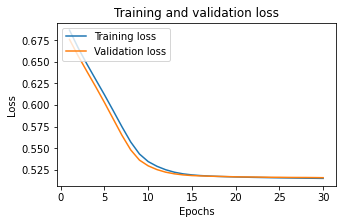

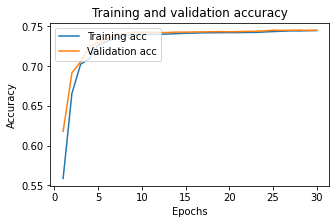

1326/1326 [==============================] - 68s 51ms/step
              precision    recall  f1-score   support

           0       0.65      0.31      0.42     12758
           1       0.76      0.93      0.83     29650

    accuracy                           0.74     42408
   macro avg       0.70      0.62      0.63     42408
weighted avg       0.73      0.74      0.71     42408

Optimized threshold for best F1: 0.50


In [57]:
# train a small lstm model with no dense layers
train_lstm(
    dataset=time_series_datasets,
    input_shape=time_series_shape,
    output_shape=output_shape,

    lstm_units=16,
    lstm_l1_regulization=0.0,
    lstm_l2_regulization=0.0,
    lstm_dropout=0.0,

    dense_layer_count=0,
    dense_units=16,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0.0,

    train_epochs=30,
    train_batch_size=2000,
    train_optimizer=optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 400, 128)]        0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,641
Trainable params: 20,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
64/64 [==============================] - 101s 2s/step - loss: 0.6835 - accuracy: 0.5752 - val_loss: 0.6621 - val_accuracy: 0.6765
Epoch 2/10
64/64 [============================

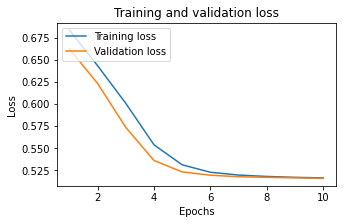

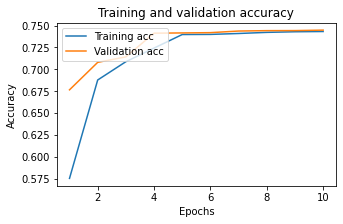

1326/1326 [==============================] - 80s 60ms/step
              precision    recall  f1-score   support

           0       0.64      0.33      0.43     12758
           1       0.76      0.92      0.83     29650

    accuracy                           0.74     42408
   macro avg       0.70      0.62      0.63     42408
weighted avg       0.72      0.74      0.71     42408

Optimized threshold for best F1: 0.50


In [58]:
# double the lstm units
train_lstm(
    dataset=time_series_datasets,
    input_shape=time_series_shape,
    output_shape=output_shape,

    lstm_units=32,
    lstm_l1_regulization=0.0,
    lstm_l2_regulization=0.0,
    lstm_dropout=0.0,

    dense_layer_count=0,
    dense_units=16,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0.0,

    train_epochs=10,
    train_batch_size=2000,
    train_optimizer=optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 400, 128)]        0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               394240    
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 394,497
Trainable params: 394,497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
64/64 [==============================] - 406s 6s/step - loss: 0.5621 - accuracy: 0.7229 - val_loss: 0.5166 - val_accuracy: 0.7436
Epoch 2/10
64/64 [==========================

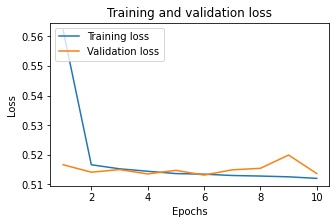

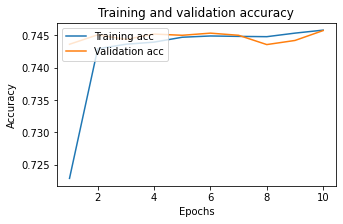

1326/1326 [==============================] - 259s 194ms/step
              precision    recall  f1-score   support

           0       0.63      0.35      0.45     12758
           1       0.77      0.91      0.83     29650

    accuracy                           0.74     42408
   macro avg       0.70      0.63      0.64     42408
weighted avg       0.73      0.74      0.72     42408

Optimized threshold for best F1: 0.50


In [60]:
# increase the lstm units by a lot
train_lstm(
    dataset=time_series_datasets,
    input_shape=time_series_shape,
    output_shape=output_shape,

    lstm_units=256,
    lstm_l1_regulization=0.0,
    lstm_l2_regulization=0.0,
    lstm_dropout=0.0,

    dense_layer_count=0,
    dense_units=16,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0.0,

    train_epochs=10,
    train_batch_size=2000,
    train_optimizer=optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

In [56]:
# still more lstm units - Massively over-fitting seems hard and will 
# need quite a large model. Will the server blow up? No one knows.
# Well know I know, seems to explode with 1024 units
train_lstm(
    dataset=time_series_datasets,
    input_shape=time_series_shape,
    output_shape=output_shape,

    lstm_units=512,
    lstm_l1_regulization=0.0,
    lstm_l2_regulization=0.0,
    lstm_dropout=0.0,

    dense_layer_count=0,
    dense_units=16,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0.0,

    train_epochs=10,
    train_batch_size=2000,
    train_optimizer=optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

2023-03-16 12:12:52.819975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 400, 128)]        0         
                                                                 
 lstm (LSTM)                 (None, 1024)              4722688   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 4,723,713
Trainable params: 4,723,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


: 

: 

In [ ]:
train_lstm(
    dataset=time_series_datasets,
    input_shape=time_series_shape,
    output_shape=output_shape,

    lstm_units=128,
    lstm_dropout=0.2,

    dense_layer_count=5,
    dense_units=128,
    dense_activation='relu',
    dense_dropout=0.2,
    
    train_epochs=10,
    train_batch_size=2000,
    train_optimizer=optimizers.RMSprop(learning_rate=0.0001),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

In [ ]:
# smaller learning rate
train_lstm(
    dataset=time_series_datasets,
    input_shape=time_series_shape,
    output_shape=output_shape,

    lstm_units=128,
    lstm_dropout=0.2,

    dense_layer_count=5,
    dense_units=128,
    dense_activation='relu',
    dense_dropout=0.2,
    
    train_epochs=10,
    train_batch_size=2000,
    train_optimizer=optimizers.RMSprop(learning_rate=1e-05),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

In [ ]:
# more units and epochs
train_lstm(
    dataset=time_series_datasets,
    input_shape=time_series_shape,
    output_shape=output_shape,

    lstm_units=512,
    lstm_dropout=0.2,

    dense_layer_count=5,
    dense_units=512,
    dense_activation='relu',
    dense_dropout=0.2,
    
    train_epochs=20,
    train_batch_size=2000,
    train_optimizer=optimizers.RMSprop(learning_rate=1e-05),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

In [ ]:
# reduce dropout
train_lstm(
    dataset=time_series_datasets,
    input_shape=time_series_shape,
    output_shape=output_shape,

    lstm_units=512,
    lstm_dropout=0.1,

    dense_layer_count=5,
    dense_units=512,
    dense_activation='relu',
    dense_dropout=0.05,
    
    train_epochs=20,
    train_batch_size=2000,
    train_optimizer=optimizers.RMSprop(learning_rate=1e-05),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)